In [3]:
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output.detach().clone().cpu())

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    activations_pretrained.clear()
    
    # 為每個 block 註冊鉤子
    for stage_idx, stage in enumerate(model.children()):
        if isinstance(stage, torch.nn.Sequential):  # 確保 stage 是一個 Sequential 模塊
            for unit_idx, unit in enumerate(stage):
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)
    # print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 32, 32, device=device)
    model.to(device)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model(arch='resnet56',data='cifar10'):
    import os
    import sys
    sys.path.append("/ssd5/Roy/pruning/pytorch_resnet_cifar10-master")
    if data == 'cifar10':
        import resnet_cifar10
        if arch == 'resnet56':
            model = resnet_cifar10.__dict__[arch]()
            path=os.path.join('/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/pretrained_models', arch + '.th')
        elif arch == 'resnet110':
            model = resnet_cifar10.__dict__[arch]()
            path=os.path.join('/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/pretrained_models', arch + '.th')
    elif data == 'cifar100':
        import resnet_cifar100
        if arch == 'resnet56':
            model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True)
        elif arch == 'resnet110':
            model = resnet_cifar100.__dict__[arch]()
            path = "/ssd5/Roy/pruning/pytorch_resnet_cifar10-master/save_resnet110_cifar100/best_model.th"
    elif data == 'imagenet':
        if arch == 'resnet50':
            from torchvision.models import resnet50, ResNet50_Weights
            model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        elif arch == 'resnet101':
            from torchvision.models import resnet101, ResNet101_Weights
            model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
    else:
        raise ValueError(
            f"Invalid dataset '{data}'. Supported options are: 'cifar10', 'cifar100', 'imagenet'."
        )

    if path:
        checkpoint = torch.load(path)
        state_dict = checkpoint['state_dict']  # 如果你的檔案裡有 `state_dict`，取出來

        new_state_dict = {}
        for key, value in state_dict.items():
            new_key = key.replace("module.", "")  # 移除 module.
            new_state_dict[new_key] = value

        model.load_state_dict(new_state_dict)

    return model

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]


def StatTest(test, arch, data, alpha):

    # 獲取預訓練權重的激活
    pretrained_model = load_pretrained_model(arch=arch,data=data)
    get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
    activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

    rows = []
    n = len(activations_pretrained_copy)
    for i in range(1, n):
        # Pretrained 模型
        act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
        act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

        act_before_pre = remove_outliers(act_before_pre)
        act_after_pre = remove_outliers(act_after_pre)

        if test == 'MW':
            # Mannwhitneyu
            u_stat_pre, p_val_pre = mannwhitneyu(act_before_pre, act_after_pre, alternative='two-sided', method='asymptotic')
        elif test == 'KS':
            # KS
            u_stat_pre, p_val_pre = ks_2samp(act_before_pre, act_after_pre)
        sig_pre = "*" if p_val_pre < alpha else ""
        mean_pre = np.mean(act_after_pre)
        std_pre = np.std(act_after_pre)

        # 使用 pretrained 模型當前 block 的輸出形狀作為參考
        output_shape = activations_pretrained_copy[i].shape
        
        rows.append([i, output_shape, mean_pre, std_pre, sig_pre, p_val_pre])

    # 建立 DataFrame
    columns = ['block_index', 
            'output shape', 
            'mean of pretrained', 'std of pretrained', 'sig of pretrained', 'p_val']
    df_stats = pd.DataFrame(rows, columns=columns)
    return df_stats


In [ ]:
test = 'MW'
arch = 'resnet56'
data = 'cifar10'
alpha = 0.05

import time  # 加在最上面
start_time = time.time()  # 開始時間

device = torch.device("cpu")
activations_pretrained = []
hooks_pretrained = []
df_stats = StatTest(test=test, arch=arch, data=data, alpha=alpha)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

display(df_stats.style.hide(axis="index"))

/tmp/ipykernel_281106/875337336.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)



Total elapsed time: 0.42 seconds


block_index,output shape,mean of pretrained,std of pretrained,sig of pretrained,p_val
1,"torch.Size([1, 16, 32, 32])",0.838649,0.924409,*,0.000126
2,"torch.Size([1, 16, 32, 32])",0.944845,1.002170,*,0.000000
3,"torch.Size([1, 16, 32, 32])",1.051778,1.079503,*,0.000000
4,"torch.Size([1, 16, 32, 32])",1.133506,1.118046,*,0.000000
5,"torch.Size([1, 16, 32, 32])",1.232977,1.199425,*,0.000000
6,"torch.Size([1, 16, 32, 32])",1.382593,1.182305,*,0.000000
7,"torch.Size([1, 16, 32, 32])",1.507999,1.139584,*,0.000000
8,"torch.Size([1, 16, 32, 32])",1.576274,1.097885,*,0.000000
9,"torch.Size([1, 32, 16, 16])",0.855625,1.006980,*,0.000000
10,"torch.Size([1, 32, 16, 16])",0.907360,0.990853,*,0.000000


# N次裡面挑出現k次的(演算法)，這件事情做100次(驗證)

In [4]:
from collections import Counter
import pandas as pd
import time

num_outer_runs = 20  # 外層重複幾次
num_inner_runs = 10    # 每次投票裡面做幾次
at_least_show = 6     # 至少出現幾次就算
alpha = 0.05

summary_rows = []
start_time = time.time()

for outer_idx in range(1, num_outer_runs + 1):
    all_blocks_this_outer = []

    for inner_idx in range(num_inner_runs):
        df_stats = StatTest(test=test, arch=arch, data=data, alpha=alpha)
        redundant_blocks = df_stats[df_stats['p_val'] > alpha]['block_index'].tolist()
        all_blocks_this_outer.extend(redundant_blocks)

    # 統計 5 次裡面每個 block 出現次數
    counts = Counter(all_blocks_this_outer)

    # 投票條件：至少出現 3 次
    voted_blocks = sorted([block for block, count in counts.items() if count >= at_least_show])

    voted_blocks_str = ','.join(map(str, voted_blocks))
    num_voted = len(voted_blocks)

    summary_rows.append([outer_idx, voted_blocks_str, num_voted])

    print(f"Outer Run {outer_idx}: Voted redundant blocks -> {voted_blocks_str}")

# --- 匯總 ---
summary_df = pd.DataFrame(
    summary_rows,
    columns=['run_index', 'voted_redundant_blocks', 'num_voted_blocks']
)

elapsed_time = time.time() - start_time
print(f"\nTotal elapsed time for {num_outer_runs} outer runs: {elapsed_time:.2f} seconds")

# 顯示或儲存
print("\nSummary of voted blocks across all runs:")
# print(summary_df.head())

# 組檔名字串
filename = f"summary_{data}_{arch}_{test}_{num_inner_runs}runs_atleast{at_least_show}.csv"

# 儲存
summary_df.to_csv(filename, index=False)

print(f"Saved summary to: {filename}")

# --- 檢查是否完全一致 ---
unique_sets = summary_df['voted_redundant_blocks'].nunique()
if unique_sets == 1:
    print("\n🎉 All runs produced the same voted redundant block set! Very stable!")
else:
    print(f"\n⚠️ Found {unique_sets} different voted block sets across {num_outer_runs} runs.")

summary_df


/tmp/ipykernel_281106/875337336.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Outer Run 1: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 2: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 3: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 4: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 5: Voted redundant blocks -> 11,12,14,16,17,20,25
Outer Run 6: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 7: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 8: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 9: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 10: Voted redundant blocks -> 11,12,14,16,17,20
Outer Run 11: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 12: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 13: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 14: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 15: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 16: Voted redundant blocks -> 11,12,13,14,16,17,20
Outer Run 17: Voted redundant blocks

,run_index,voted_redundant_blocks,num_voted_blocks
0,1,"11,12,13,14,16,17,20",7
1,2,"11,12,13,14,16,17,20",7
2,3,"11,12,13,14,16,17,20",7
3,4,"11,12,13,14,16,17,20",7
4,5,"11,12,14,16,17,20,25",7
5,6,"11,12,13,14,16,17,20",7
6,7,"11,12,13,14,16,17,20",7
7,8,"11,12,13,14,16,17,20",7
8,9,"11,12,13,14,16,17,20",7
9,10,"11,12,14,16,17,20",6


In [41]:
from collections import Counter

# 攤平成一個大串列
all_blocks = []
for row in summary_df['voted_redundant_blocks']:
    blocks = row.split(',')
    all_blocks.extend(blocks)

counts = Counter(all_blocks)
print("\nBlock 出現次數統計：")
for block, count in counts.most_common():
    print(f"Block {block}: {count} times, {count/100:.1%}")



Block 出現次數統計：
Block 11: 20 times, 20.0%
Block 17: 12 times, 12.0%
Block 14: 10 times, 10.0%


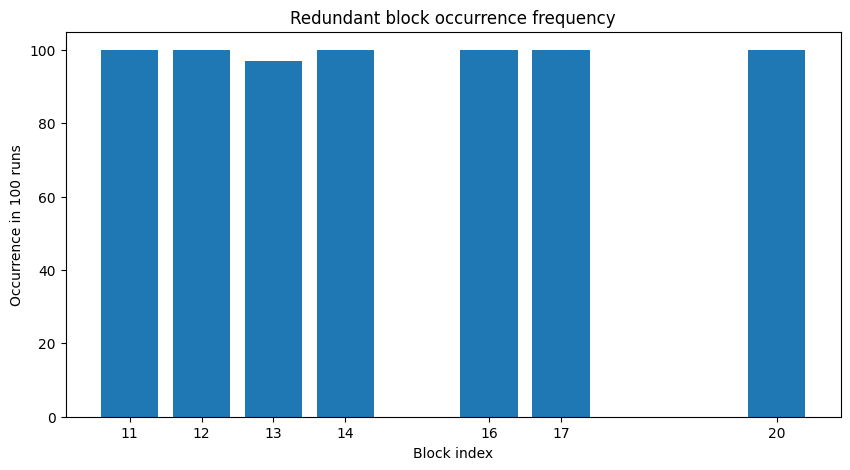

In [5]:
import matplotlib.pyplot as plt

blocks = list(map(int, counts.keys()))
freqs = list(counts.values())

plt.figure(figsize=(10, 5))
plt.bar(blocks, freqs)
plt.xlabel("Block index")
plt.ylabel("Occurrence in 100 runs")
plt.title("Redundant block occurrence frequency")
plt.xticks(blocks)
plt.show()


## R2sample

In [18]:
# Re-run the full implementation after kernel reset

import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp, anderson_ksamp, cramervonmises_2samp
import pandas as pd
import matplotlib.pyplot as plt

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

def estimate_power(x, y, methods=None, B=200, alpha=0.05, sample_size=300):
    if methods is None:
        methods = ['T-test', 'MW', 'KS', 'AD', 'CvM']

    power_count = {method: 0 for method in methods}

    x = remove_outliers(np.asarray(x).flatten())
    y = remove_outliers(np.asarray(y).flatten())

    for _ in range(B):
        x_sample = np.random.choice(x, size=sample_size, replace=False)
        y_sample = np.random.choice(y, size=sample_size, replace=False)

        if 'T-test' in methods:
            p = ttest_ind(x_sample, y_sample).pvalue
            if p < alpha:
                power_count['T-test'] += 1

        if 'MW' in methods:
            p = mannwhitneyu(x_sample, y_sample, alternative='two-sided').pvalue
            if p < alpha:
                power_count['MW'] += 1

        if 'KS' in methods:
            p = ks_2samp(x_sample, y_sample).pvalue
            if p < alpha:
                power_count['KS'] += 1

        if 'AD' in methods:
            try:
                p = anderson_ksamp([x_sample, y_sample]).significance_level / 100
                if p < alpha:
                    power_count['AD'] += 1
            except:
                continue

        if 'CvM' in methods:
            try:
                p = cramervonmises_2samp(x_sample, y_sample).pvalue
                if p < alpha:
                    power_count['CvM'] += 1
            except:
                continue

    power = {method: power_count[method] / B for method in methods}
    return power

def plot_power_vs_alpha(x, y, methods=None, alphas=None, B=300, sample_size=15000):
    if alphas is None:
        alphas = [0.01, 0.03, 0.05, 0.07, 0.1]

    results = []
    for a in alphas:
        pwr = estimate_power(x, y, methods=methods, B=B, alpha=a, sample_size=sample_size)
        pwr['alpha'] = a
        results.append(pwr)

    df = pd.DataFrame(results)
    df_melted = df.melt(id_vars='alpha', var_name='method', value_name='power')

    plt.figure(figsize=(10, 6))
    for method in df_melted['method'].unique():
        subset = df_melted[df_melted['method'] == method]
        plt.plot(subset['alpha'], subset['power'], marker='o', label=method)

    plt.xlabel("Alpha level")
    plt.ylabel("Estimated Power")
    plt.title("Power vs Alpha for Various Statistical Tests")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df


/tmp/ipykernel_350981/875337336.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)
/tmp/ipykernel_350981/710587952.py:46: UserWarning: p-valu

16384


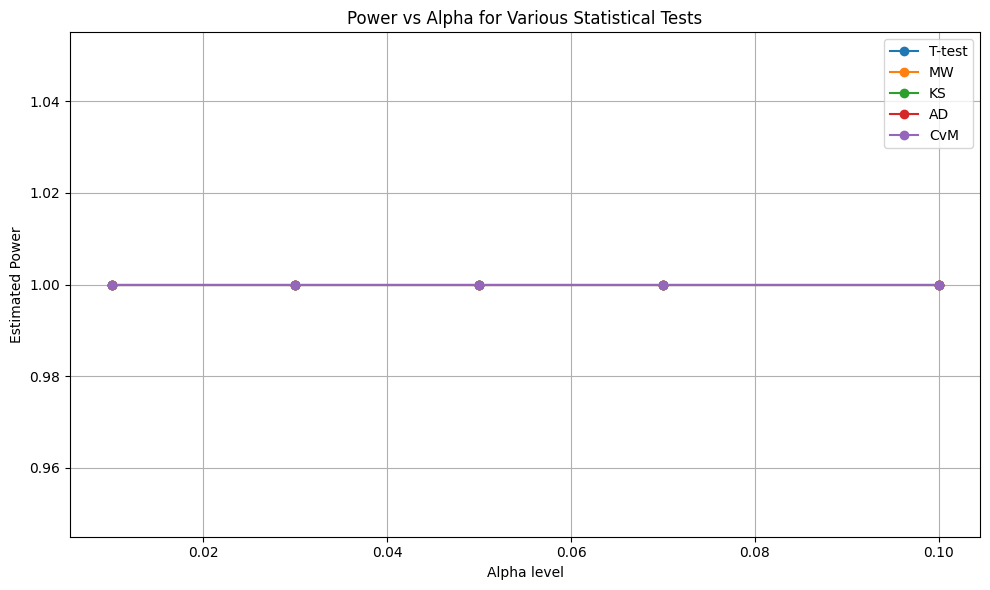

,T-test,MW,KS,AD,CvM,alpha
0,1.0,1.0,1.0,1.0,1.0,0.01
1,1.0,1.0,1.0,1.0,1.0,0.03
2,1.0,1.0,1.0,1.0,1.0,0.05
3,1.0,1.0,1.0,1.0,1.0,0.07
4,1.0,1.0,1.0,1.0,1.0,0.10


In [19]:
arch = 'resnet56'
data = 'cifar10'
hooks_pretrained = []
activations_pretrained = []
device = torch.device("cpu")

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model(arch=arch,data=data)
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

x = activations_pretrained_copy[0].numpy().flatten()
y = activations_pretrained_copy[1].numpy().flatten()
print(len(x))

plot_power_vs_alpha(x,y)

/tmp/ipykernel_350981/3564319187.py:51: UserWarning: p-value capped: true value larger than 0.25
  p_ad = anderson_ksamp([a, b]).significance_level / 100


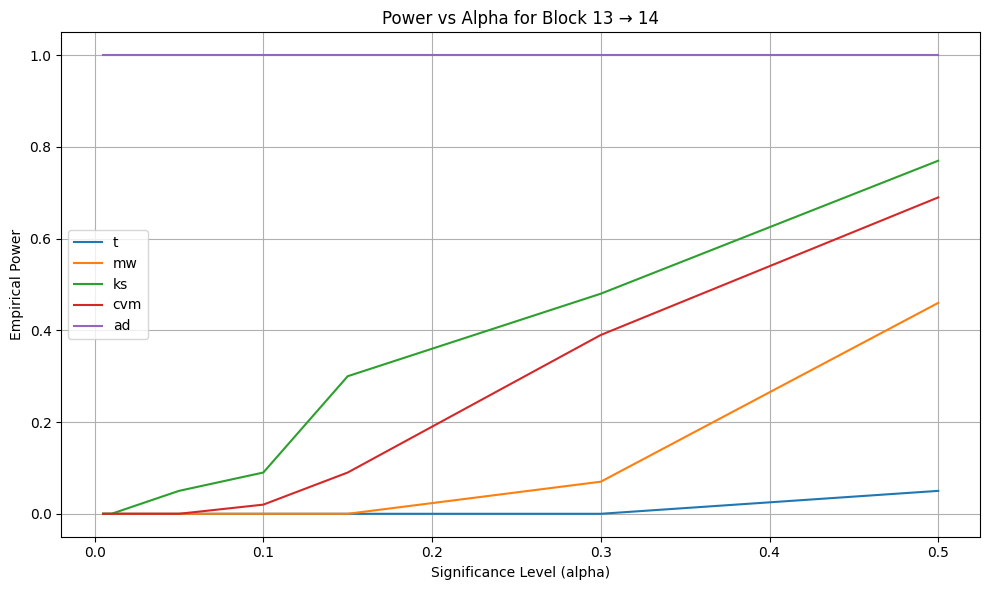

In [31]:
import matplotlib.pyplot as plt

# 你要比較的 block index（例如第 i 層和第 i+1 層）
target_block = 14
# alphas = np.linspace(0.001, 0.1, 30)
alphas = [0.005, 0.01, 0.05, 0.1, 0.15, 0.3, 0.5]
B = 100  # 模擬次數

# 初始化每個 alpha 值下的 power 結果
alpha_power_dict = {
    't': [], 'mw': [], 'ks': [], 'cvm': [], 'ad': []
}

for alpha in alphas:
    results_dict = {
        't': [], 'mw': [], 'ks': [], 'cvm': [], 'ad': []
    }

    for _ in range(B):
        get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
        acts = activations_pretrained.copy()

        a = remove_outliers(acts[target_block - 1].numpy().flatten())
        b = remove_outliers(acts[target_block].numpy().flatten())

        try:
            _, p_t = ttest_ind(a, b, equal_var=False)
        except:
            p_t = 1.0
        results_dict['t'].append(p_t < alpha)

        try:
            _, p_mw = mannwhitneyu(a, b, alternative='two-sided')
        except:
            p_mw = 1.0
        results_dict['mw'].append(p_mw < alpha)

        try:
            _, p_ks = ks_2samp(a, b)
        except:
            p_ks = 1.0
        results_dict['ks'].append(p_ks < alpha)

        try:
            p_cvm = cramervonmises_2samp(a, b).pvalue
        except:
            p_cvm = 1.0
        results_dict['cvm'].append(p_cvm < alpha)

        try:
            p_ad = anderson_ksamp([a, b]).significance_level / 100
        except:
            p_ad = 1.0
        results_dict['ad'].append(p_ad < alpha)

    for test in alpha_power_dict:
        alpha_power_dict[test].append(np.mean(results_dict[test]))

# 畫出不同 alpha 值下的 power 曲線
plt.figure(figsize=(10, 6))
for test in alpha_power_dict:
    plt.plot(alphas, alpha_power_dict[test], label=test)
plt.xlabel("Significance Level (alpha)")
plt.ylabel("Empirical Power")
plt.title(f"Power vs Alpha for Block {target_block-1} → {target_block}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
